In [ ]:
# bayes rule
# bayes theorem

# objective: estimate the population parameter for some data
# e.g. the true rate of flu infection
# N people in your population
# f people get the flu
# p = f/N

# frequentist statistician
# p is fixed but unknown
# estimate the rate by collecting a sample
# and report the sample proportion (with confidence intervals)

# bayesian
# there's a lot of uncertainty around p
# so use a probility distribution to describe p, don't use a single number
# will report the whole probability distribution

# tldr, to sum it up: 
# frequentist -> parameters are fixed values
# bayesian -> parameters are better represented by distributions

In [ ]:
# let's go through an example
# online advertising: clicks/views <- which ads to run?
# sports: goals/shots <- moneyball - which players to keep?
# healthcare: survived/got sick <- which medicines to push?
# gaming: wins/plays (lottery, casino games, ...) <- these are very well understood and predictable (not by you, but by the "house") 
# ...

# suppose we do an experiment

# target variable is p (successes/attempts)

# treatment T - like different design for the online ads, different players, different medicines (or no medicine)

# frequentist - null hypothesis sig testing

# (for simplicity assume we have two groups, A and B)

# H0: p_A = p_B 
# H1: not H0

# ... sweeping details about experimental design under the rug ... 

# do a test (proportions z test)

# calculate a z-statistic -> get a p-value -> if p is small, reject H0 -> conclude there's a difference

In [2]:
# bayesian

# you make a "data generating function" representing your data
# e.g. height ~ Normal(mu,sigma)
# you can take random samples from Normal(mu,sigma)
# in this sense, you have made a function that generates heights

# make a data generating function for p (successes/attempts)

# success ~ Binomial(attempts,p)

# p is not fixed, p is a probability distribution

# there's probability function, that is great for modeling proportions
# it's called the Beta distribution
# it has two parameters alpha, beta

# instead of saying p = .335

# we will say p ~ Beta(50,100)

# motivation - suppose we are very interested in knowing p (success/attempts)
# for something that we don't have a lot of data for
# sports: a rookie player 
# medicine: a drug that just came out

# baseball - if someone has only 10 at bats, and 1 hit. 
# a batting average of .1 should get them fired right?
# p = .1 - bad, highly uncertain estimate

# let's first develop a global understanding of success rate (across individuals)
# then make small adjustments based on evidence for a particular person

import pandas as pd
df = pd.read_csv('lahman_1871-2023_csv/lahman_1871-2023_csv/Batting.csv')
df = df[['playerID','yearID','AB','H']]

In [ ]:
# 1. i'm going to make a data generating function for p = H/AB
# and estimate alpha and beta USING THE DATA

# 2. going to use 1.) to estimate the "true" p for the player with 1/10
# compare it to the estimate above p = 1/10 = .1

# then we can decide which is more reasonable

In [6]:
# 1. 
df = df.groupby("playerID").agg({"AB":"sum","H":"sum"})
df = df[df['AB'] >= 500]

In [12]:
import numpy as np
from scipy.stats import beta

# how we find the best alpha and beta is unimportant (for... us... right now)
# just know there's a few different ways to do it
# rabbit hole: method of moments, maximum likilihood estimation, ...

df['success_rate'] = df['H'] / df['AB']

mean_success = df['success_rate'].mean()
var_success = df['success_rate'].var()

# validate with beta distribution
a, b, loc, scale = beta.fit(df['success_rate'], floc=0, fscale=1)
a = round(a,0)
b = round(b,0)
print(f"Beta distribution parameters from fit: alpha = {a}, beta = {b}")

Beta distribution parameters from fit: alpha = 91.0, beta = 236.0


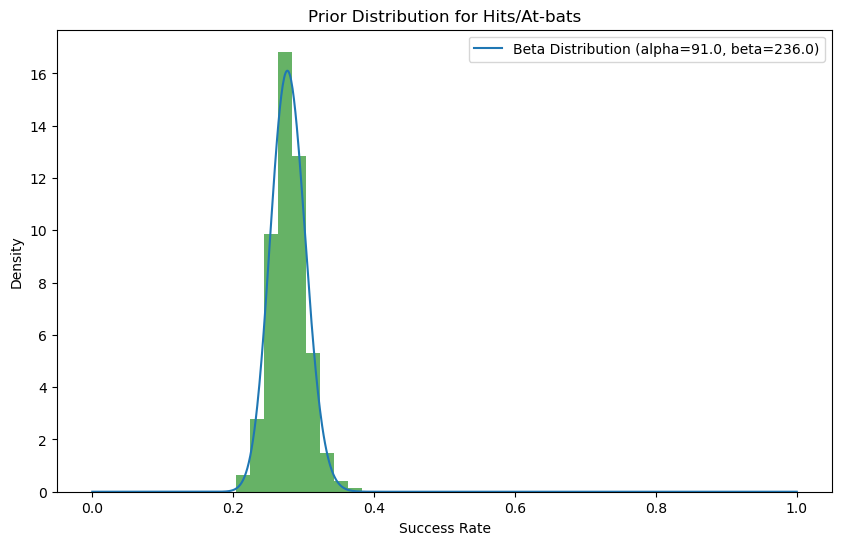

In [14]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a, b)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Beta Distribution (alpha={a}, beta={b})')
plt.hist(df['success_rate'], bins=10, density=True, alpha=0.6, color='g')
plt.xlabel('Success Rate')
plt.ylabel('Density')
plt.title('Prior Distribution for Hits/At-bats')
plt.legend()
plt.show()

In [ ]:
# before we get to step 2
# suppose we want to invite ppl to the all star game
# we can't have too many people at the all star game
# requirement that success rate be so hard to achieve that only 1% of people achieve it
# our requirement is .337 to ensure only 1% of people make it

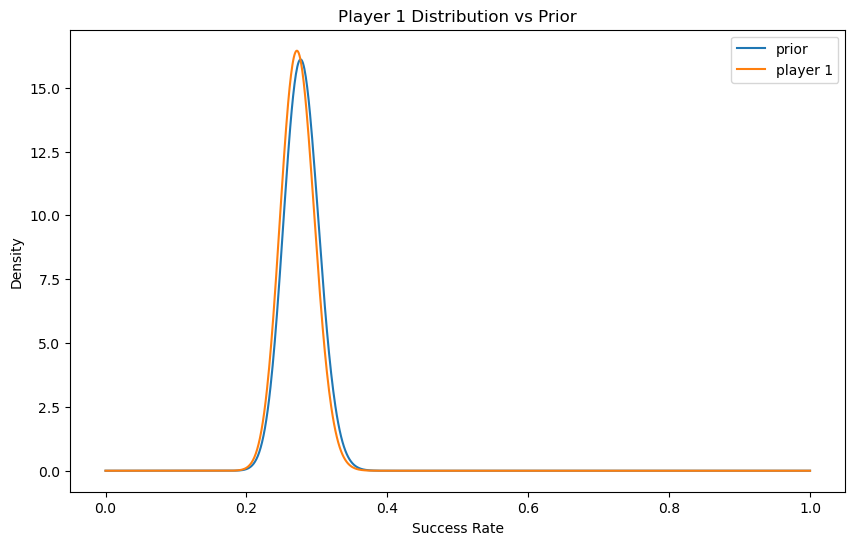

In [17]:
# step 2

# how can we use this to come up with a more honest estimate for the rookie player

# the bayesian approach lets you use this prior distribution
# then "update" the prior to reflect evidence from the individual

# we are going make a new alpha,beta for this player
# so they will have their own distribution

# to update a beta distribution

# player 1, Hit=1, AB=10, Misses=9

# alpha_player1 = alpha + player_1Hits
# beta_player1 = beta + player1_Misses

x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a, b)
y_player1 = beta.pdf(x,a + 1,b + 9)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'prior')
plt.plot(x, y_player1, label=f'player 1')
# plt.hist(df['success_rate'], bins=10, density=True, alpha=0.6, color='g')
plt.xlabel('Success Rate')
plt.ylabel('Density')
plt.title('Player 1 Distribution vs Prior')
plt.legend()
plt.show()


In [22]:
# this is more fair than saying "his batting average is .1"

# to motivate this further
# you could also calculate the frequentist confidence interval for p = .1


import statsmodels.stats.proportion as smp

smp.proportion_confint(count=1, nobs=10, alpha=.05, method='normal')

(0.0, 0.866767964039479)

In [23]:
# his batting average is .1
# and pretty sure it's between 0 and .28

# bayesian approach is simply
# find the lower bound, and upper bound that give 95% probability density

def beta_confidence_interval(alpha, beta_param, confidence=0.95):
    lower_bound = beta.ppf((1 - confidence) / 2, alpha, beta_param)
    upper_bound = beta.ppf(1 - (1 - confidence) / 2, alpha, beta_param)
    
    return lower_bound, upper_bound

beta_confidence_interval(a + 1, b + 10)


(0.23107112472682115, 0.3273616212520692)

In [24]:
# suppose you did really well in your rookie season
# are you better than this other player with a thousand at bats?
2/3, 337/1000

(0.6666666666666666, 0.337)

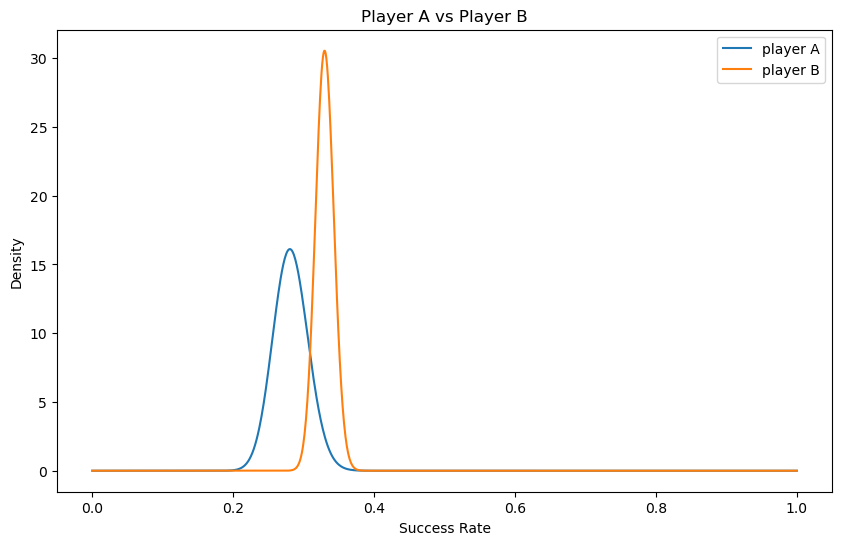

In [25]:
# you have prior distribution for success rate

# player A - player B who is better?

playerA_hits = 2
playerA_AB = 3

playerB_hits = 337
playerB_AB = 1000

# who's better
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a + 2, b + 1)
y_player1 = beta.pdf(x,a + 337,b + 633)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'player A')
plt.plot(x, y_player1, label=f'player B')
# plt.hist(df['success_rate'], bins=10, density=True, alpha=0.6, color='g')
plt.xlabel('Success Rate')
plt.ylabel('Density')
plt.title('Player A vs Player B')
plt.legend()
plt.show()


In [27]:
# take samples from each beta distribution
# mean(sampleA > sampleB)
# probability that A is better than B
num_samples = 100000
samples_a = beta.rvs(a + 2, b + 1, size=num_samples)
samples_b = beta.rvs(a + 337,b + 633, size=num_samples)

# calculate the probability that samples from A are greater than samples from B
np.mean(samples_a > samples_b)

0.04478

In [ ]:
# probability that A is better than B is 4.5%